# Week 10 Assignment: Sentiment Analysis

**Brian Roepke**  
*DATA 110*

For the given dataset perform sentiment analysis using  1) Machine Learning and 2) Lexicon-based techniques.  Refer to assigned reading (especially ch 7), supplementals, or conduct your own research.

Requirements:

1) Perform full EDA,  including key statistics and visualizations.

2) Perform required text preprocessing and feature vectorization (Eg: TF-IDF)

3) Modeling: Create ML and Lexicon-based models.

 a) Machine learning:

 - create a new column (sent_label) for the target based on reviews.rating, where  1, 2, or 3 are labeled as 0 (negative) while 4 or greater are labeled as 1 (positive)

- Use any appropriate ML algorithm (eg: SVM, Logistic Regression, etc...)  and create 3 different models using pipelines. 

- Use cross-validation (StratifiedKFold for imbalanced datasets) to compare each of the models for model selection.

- Consider the case of imbalanced dataset (Eg: significantly more positive reviews versus negative reviews). 



b) Lexicon: use any of the lexicons such as VADER or SentiWordNet.

4) Assess performance using appropriate performance metrics. Compare performance between the two approaches.

5) For both approaches, provide visualizations of the most common words in negative and positive reviews.  These can be bar plots, word clouds, etc.

In [1]:
import numpy as np
import pandas as pd
import re


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("Amazon_Consumer_Reviews.csv")

# EDA

In [3]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda


## Data Clean Up
**Change Data Types**
As needed, adjust certain datatypes to better suit analysis
 - **Date Time**: Any Date time field should be converted into their appropriate types
 - **Drop Unused Fields**: Certain fields will not add to the analysis of this data and can be droped.
 - **Referer**: Create a new column for the referring domain
 - **Categories**: Certain types of fields are better suited as categories vs. objects.  These are the fields with a limited number of entries such as Category, and Manufacturer.

In [4]:
# Date Time Conversion
df['dateAdded']= pd.to_datetime(df['dateAdded'])
df['dateUpdated']= pd.to_datetime(df['dateUpdated'])
df['reviews.date']= pd.to_datetime(df['reviews.date'])

In [5]:
def get_domain(x):
    
    m = re.findall('://([\w\-\.]+)', x)
    
    try:
        return m[0]
    except:
        return None

In [6]:
df['domain'] = df['reviews.sourceURLs'].apply(lambda x: get_domain(x))

In [7]:
# Change to Categorical types
df["brand"] = df["brand"].astype('category')
df["primaryCategories"] = df["primaryCategories"].astype('category')
df["manufacturer"] = df["manufacturer"].astype('category')
df["reviews.username"] = df["reviews.username"].astype('category')
df["domain"] = df["domain"].astype('category')

In [8]:
df.drop(columns=['id', 'manufacturerNumber', 'keys', 'categories', 'reviews.dateSeen', 'asins'], inplace=True)

## EDA

In [9]:
df.head()

,dateAdded,dateUpdated,name,brand,primaryCategories,manufacturer,reviews.date,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,domain
0,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,AmazonBasics,2017-03-02 00:00:00+00:00,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,www.amazon.com
1,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,AmazonBasics,2016-08-31 00:00:00+00:00,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,www.amazon.com
2,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,AmazonBasics,2016-12-06 00:00:00+00:00,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,www.amazon.com
3,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,AmazonBasics,2016-03-28 00:00:00+00:00,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,www.amazon.com
4,2015-10-30 08:59:32+00:00,2019-04-25 09:08:16+00:00,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,AmazonBasics,2017-04-22 00:00:00+00:00,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,www.amazon.com


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   dateAdded           28332 non-null  datetime64[ns, UTC]
 1   dateUpdated         28332 non-null  datetime64[ns, UTC]
 2   name                28332 non-null  object             
 3   brand               28332 non-null  category           
 4   primaryCategories   28332 non-null  category           
 5   manufacturer        28332 non-null  category           
 6   reviews.date        28332 non-null  datetime64[ns, UTC]
 7   reviews.numHelpful  16115 non-null  float64            
 8   reviews.rating      28332 non-null  int64              
 9   reviews.sourceURLs  28332 non-null  object             
 10  reviews.text        28332 non-null  object             
 11  reviews.title       28332 non-null  object             
 12  reviews.username    28332 non-nu

In [11]:
df.describe()

,reviews.numHelpful,reviews.rating
count,16115.000000,28332.000000
mean,0.529321,4.514048
std,9.345017,0.934957
min,0.000000,1.000000
25%,0.000000,4.000000
50%,0.000000,5.000000
75%,0.000000,5.000000
max,621.000000,5.000000


In [12]:
df.shape

(28332, 14)

In [13]:
# get categorical data
cat_data = df.select_dtypes(include=['category'])
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   brand              28332 non-null  category
 1   primaryCategories  28332 non-null  category
 2   manufacturer       28332 non-null  category
 3   reviews.username   28332 non-null  category
 4   domain             28332 non-null  category
dtypes: category(5)
memory usage: 810.2 KB


In [14]:
# show counts values of each categorical variable
for colname in cat_data.columns:
    print (colname)
    print (cat_data[colname].value_counts(), '\n')

brand
Amazon          16153
Amazonbasics    12169
AmazonBasics       10
Name: brand, dtype: int64 

primaryCategories
Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Electronics,Furniture              2
Home & Garden                      2
Name: primaryCategories, dtype: int64 

manufacturer
Amazon                     16130
AmazonBasics               12179
Amazon Digital Services       18
Amazon.com                     5
Name: manufacturer, dtype: int64 

reviews.username
ByAmazon Customer     889
Mike                   63
ByKindle Customer      45
Dave                   44
Chris                  38
                     ... 
ByRatqueen Reader       1
ByRaul Villarreal       1
ByRay J Carstensen      1
ByRay Ray               1
ztlbxx                  1
Name: reviews.username, Le

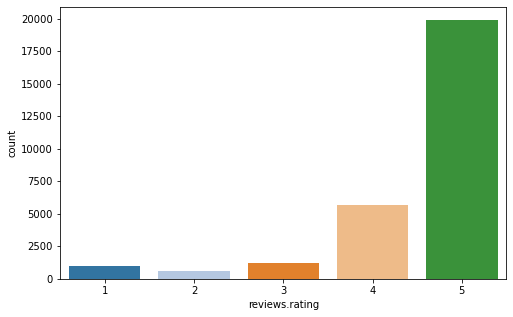

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(x='reviews.rating', data=df, palette="tab20", dodge=False);

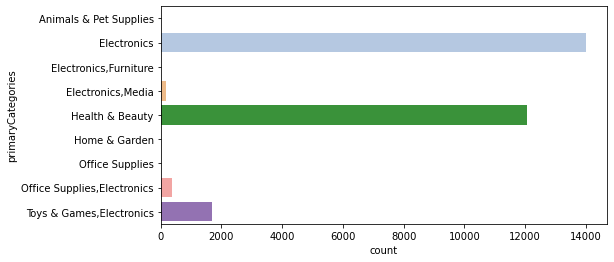

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(y='primaryCategories', data=df, palette="tab20", orient='v');

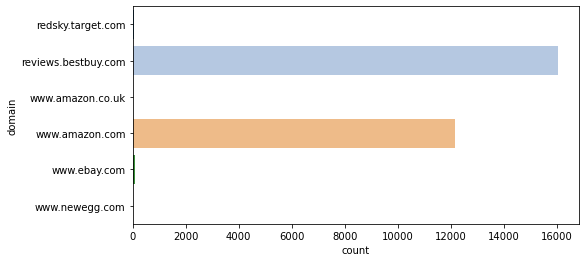

In [17]:
plt.figure(figsize=(8,4))
sns.countplot(y='domain', data=df, palette="tab20", orient='v');

# Preprocessing

# Machine learning